<a href="https://colab.research.google.com/github/supertime1/BP_PPG/blob/master/BP_Data_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Introduction

This notebook processes the ABP and PPG signals from MIMIC-III waveform database.
(https://archive.physionet.org/physiobank/database/mimic3wdb/matched/ ）


The output of this notebook is PPG signals with 5s segements at 125 Hz, with systolic and diastolic BP as numeric labels. The output data will be used to train a PPG_BP model in PPG_BP notebook.


The data cleaning and preprocessing is inspired by the following workflow, with some minor modification for our own application, where the order is:
1. Normalization
2. Segmentation
3. Flat line removal
4. Band-pass filter
5. Hampel filter

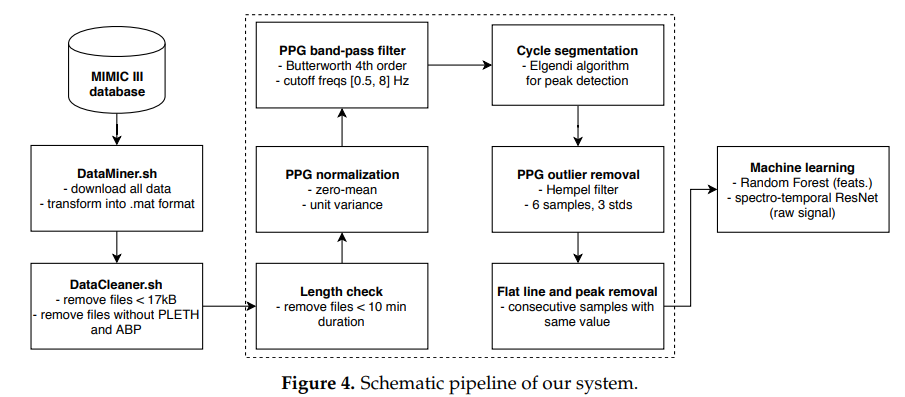

#2.Setup Environment

In [0]:
%matplotlib inline
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import wfdb
import sklearn
from sklearn import preprocessing
import io
import pickle
import numba
from numba import jit
import tensorflow as tf
from scipy.signal import find_peaks

#3.Mine ABP and PPG data from WFDB

In [0]:
hd_names = []
for name in glob.glob("D:/WFDB//matched/*/*/[0-9]*[!layout][!n].dat"):
  if os.path.getsize(name) < 17*1024:
    continue
  position = name.index('.')
  name = name[0:position] #remove the .hea part to comply the wfdb.rdrecord format
  hd_names.append(name)
print("There are total ", len(hd_names), "records that are bigger than 17kb")

There are total  363716 records that are bigger than 17kb


In [0]:
qualified_names = [] #a list of file names that contain both PPG and ABP waveforms
for name in hd_names:
  record = wfdb.rdheader(name)
  if 'ABP' in record.sig_name and 'PLETH' in record.sig_name and record.sig_len >= 75000: #only extract records contrains ECG lead I and PPG, and >=10min
    qualified_names.append(name)
print('There are total', len(qualified_names), 'records that have both ABP and PPG with more than 10min recording')

with open('D:/WFDB//matched/BP/qualified_names.pkl', "wb") as fp:
  pickle.dump(qualified_names, fp)

There are total 54440 records that have both ABP and PPG with more than 10min recording


In [0]:
def mine_data(qualified_names):
  ABP_signals = [] #create a  list to store all  ABP signals
  PPG_signals = [] #create a  list to store all  PPG signals
  n=0
  for name in qualified_names:
    record = wfdb.rdrecord(name)

    ABP_index = record.sig_name.index('ABP')
    PPG_index = record.sig_name.index('PLETH')
    ABP_sig = record.p_signal.T[ABP_index]
    PPG_sig = record.p_signal.T[PPG_index]

    if np.isnan(ABP_sig).any() or np.isnan(PPG_sig).any(): ##remove list with all empty signals
      continue
    else:
      ABP_signals.append(ABP_sig)
      PPG_signals.append(PPG_sig)
      n+=1
    
    #for every 500 samples, save to disk to release the RAM space
    if n%100 == 0:
      print("saving data No." + str(n//100))
      #save ABP data
      with open('D:/WFDB//matched/BP/ABP_signals_'+str(n//100)+'.pkl', "wb") as fp:
        pickle.dump(ABP_signals, fp)
      #save PPG data
      with open('D:/WFDB//matched/BP/PPG_signals_'+str(n//100)+'.pkl', "wb") as fp:
        pickle.dump(PPG_signals, fp)
      #clear up space in the list
      ABP_signals.clear()
      PPG_signals.clear()

    else:
      continue
  
  #save the last <100 ABP data
  with open('D:/WFDB//matched/BP/ABP_signals_'+str(n//100 + 1)+'.pkl', "wb") as fp:
    pickle.dump(ABP_signals, fp)
  #save the last <500 PPG data
  with open('D:/WFDB//matched/BP/PPG_signals_'+str(n//100 + 1)+'.pkl', "wb") as fp:
    pickle.dump(PPG_signals, fp)
  
  return None

In [0]:
mine_data(qualified_names)

#4.Process PPG and ABP raw data

In [0]:
with open('D:/WFDB//matched/BP/PPG_signals_2.pkl', "rb") as fp:
  PPG_raw_signals = pickle.load(fp)

In [0]:
with open('D:/WFDB//matched/BP/ABP_signals_2.pkl', "rb") as fp:
  ABP_raw_signals = pickle.load(fp)

C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


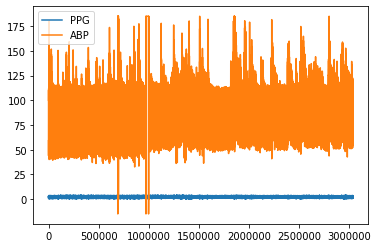

In [4]:
plt.plot(PPG_raw_signals[1],label="PPG")
plt.plot(ABP_raw_signals[1],label="ABP")
plt.legend()

##4.1 Flat line removal

To remove the flatline of a record: if 10% of the signals are made of flatline, then the entire record is removed. The flatline is defined as the change of consecutive points is smaller than a pre-defined threshold. In this notebook, the threshold has been set to 0, whereas a more reasonable value would come from histgram analysis of diff.


In [0]:
@jit(nopython=True)
def flat_line(signals,threshold = 0, percent = .15):
  clean_signals = []
  #create a list to store the index of the removed segments, this will be used
  #to remove the PPG signals with same index
  rm_list = []
  for i in range(len(signals)):
    #use np.diff to find consecutive points: diff = [i] - [i+1]
    signal_diff = np.diff(signals[i])
    #change value less than threshold to 0, and the rest to 1
    less = np.abs(signal_diff) <= threshold
    more = np.abs(signal_diff) > threshold
    signal_diff[less] = 0
    signal_diff[more] = 1
    #calculate what percent of 0 in the signal, remove the entire signal if 
    #percentage is higher than defined percent
    zero_per = np.sum(signal_diff==0)/len(signal_diff)
    if zero_per < percent:
      clean_signals.append(signals[i])
    else:
      rm_list.append(i)
    
    #track the progress for impatient programmer
    #if i%10000 == 0:
      #print("Processing on", i, "th sample")

  return clean_signals,rm_list

###4.1.1 PPG flat line removal

In [6]:
PPG_clean_signals,PPG_rm_list = flat_line(PPG_raw_signals,0,percent=0.10)

C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\numba\ir_utils.py:1959: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'signals' of function 'flat_line'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-5-a6627cf83ef7>", line 2:
@jit(nopython=True)
def flat_line(signals,threshold = 0, percent = .15):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [7]:
print('There are',len(PPG_clean_signals),'accepted PPG segments')
print('There are',len(PPG_rm_list),'rejected PPG segements that have flat line region more than ~10%')

There are 46 accepted PPG segments
There are 54 rejected PPG segements that have flat line region more than ~10%


C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


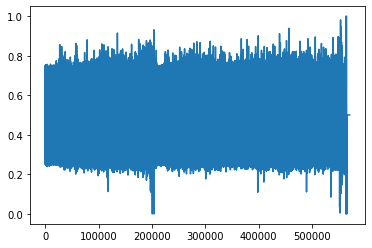

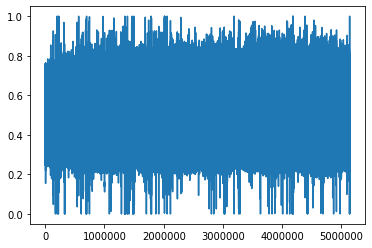

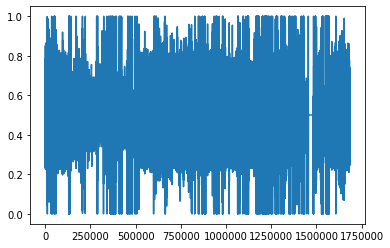

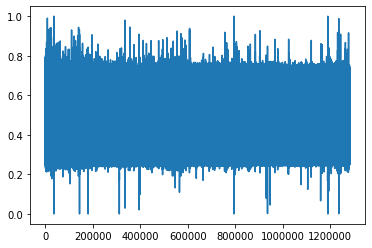

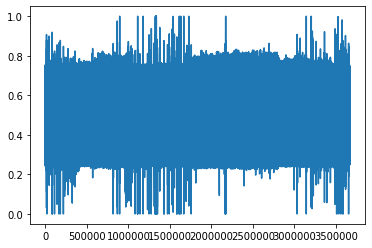

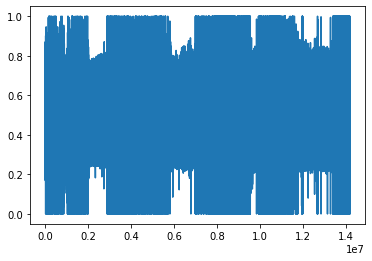

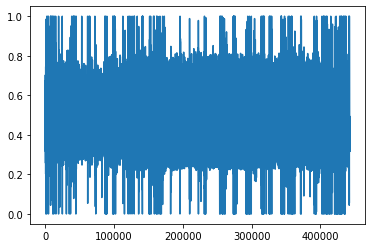

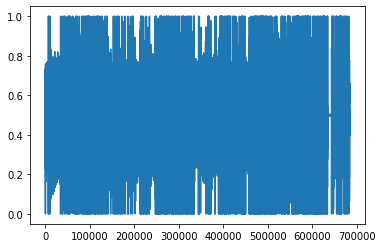

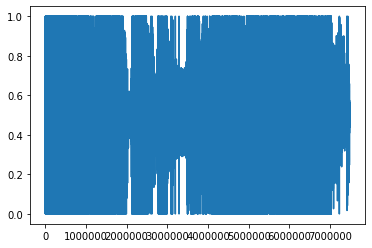

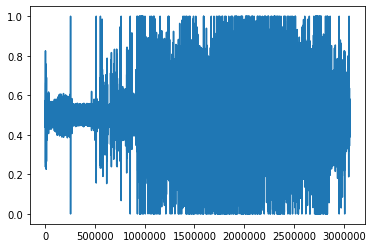

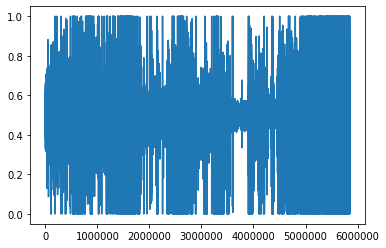

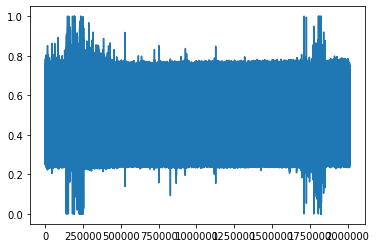

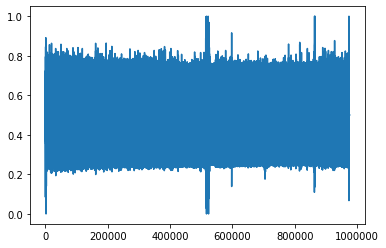

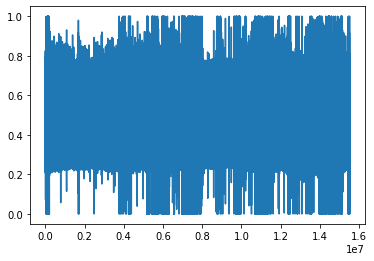

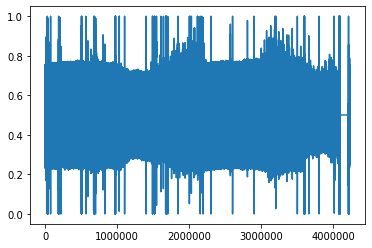

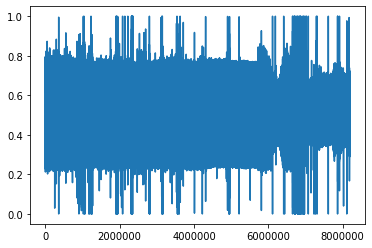

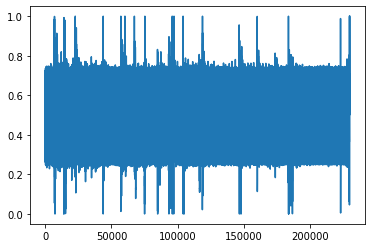

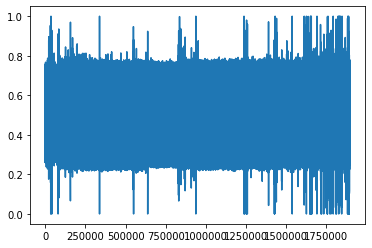

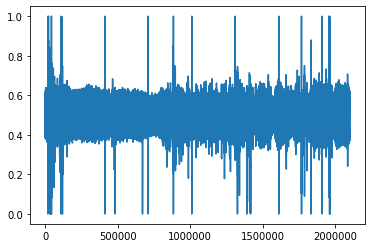

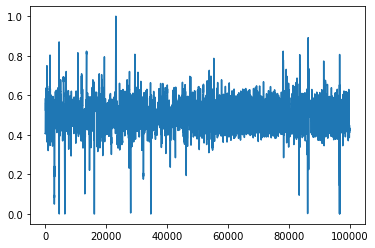

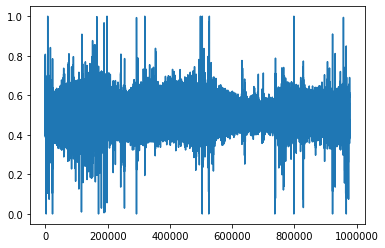

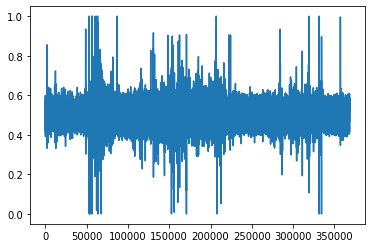

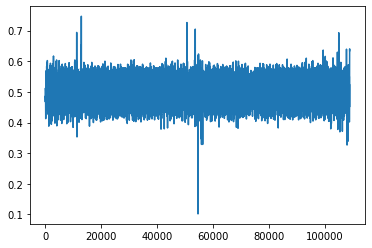

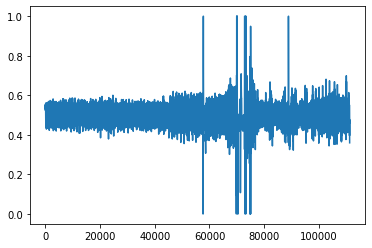

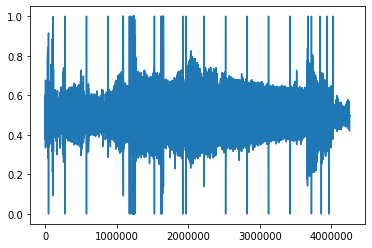

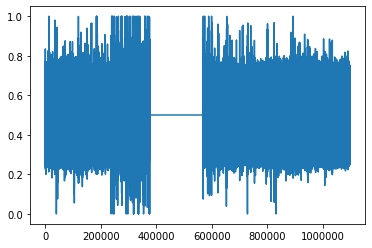

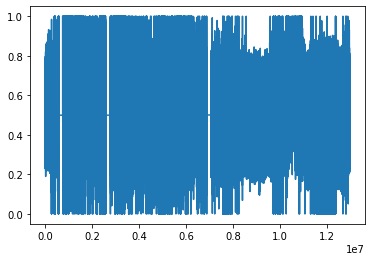

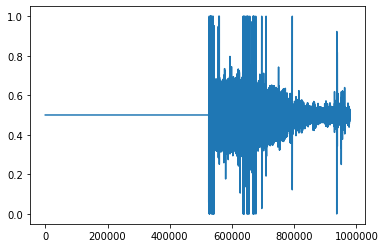

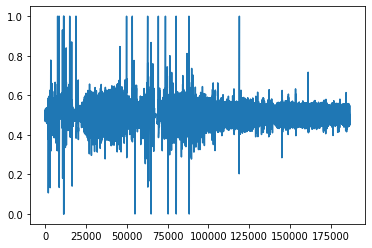

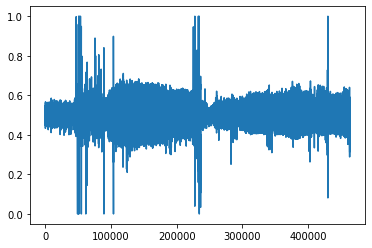

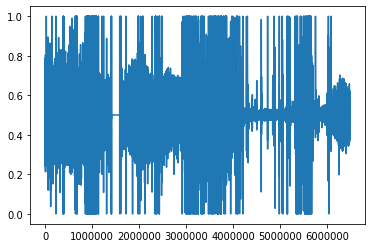

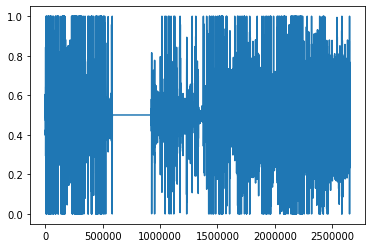

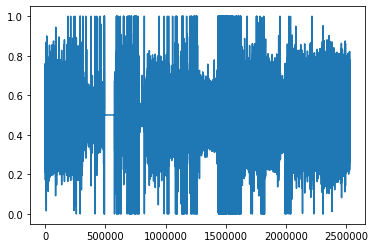

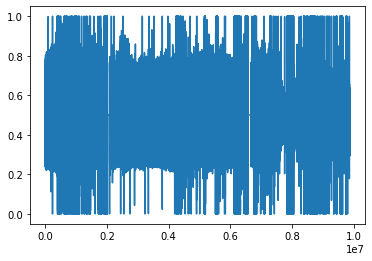

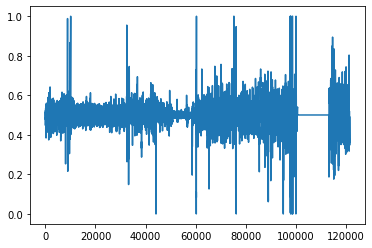

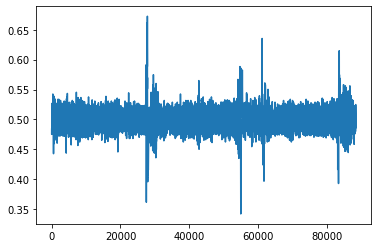

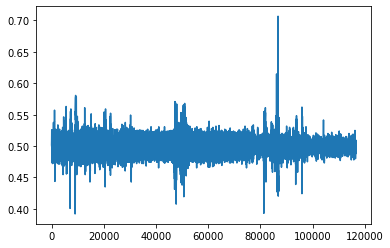

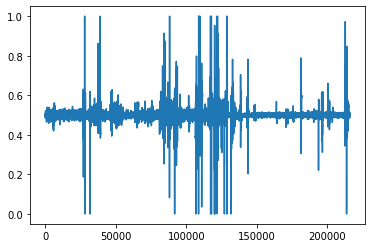

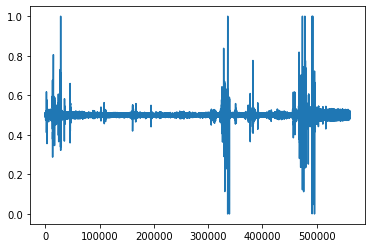

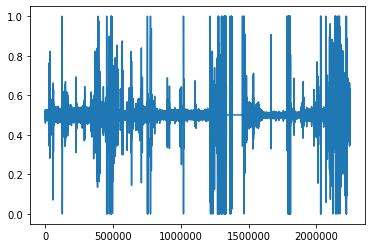

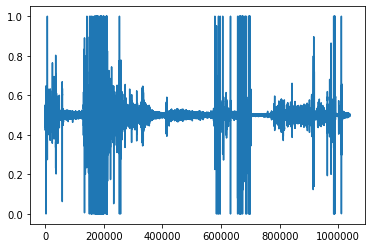

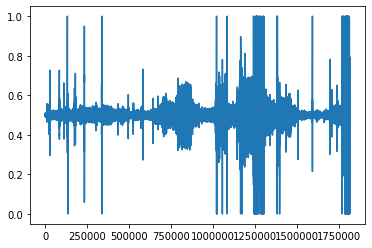

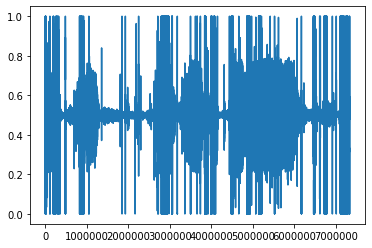

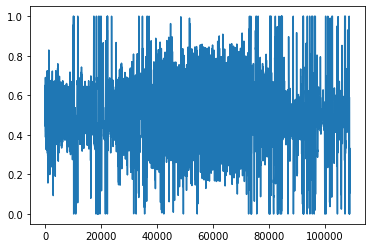

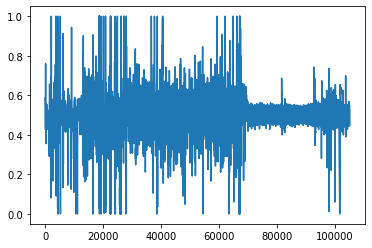

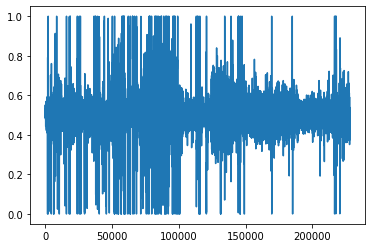

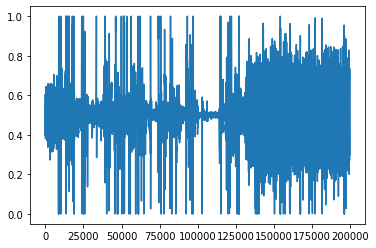

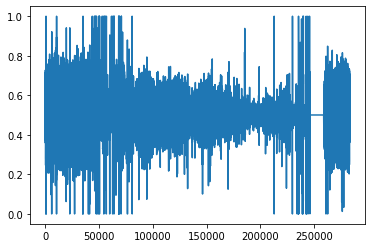

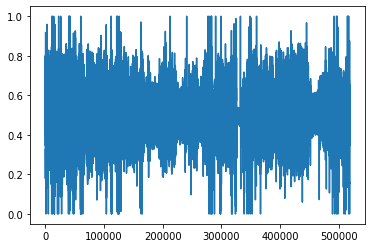

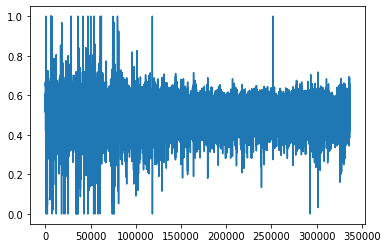

In [8]:
#take the fist 100 samples to see the rejected segements
for i in range(len(PPG_rm_list[:50])):
  x = PPG_rm_list[i]
  plt.figure()
  plt.plot(PPG_raw_signals[x])

###4.1.2 ABP flat line removal

In [0]:
ABP_clean_signals,ABP_rm_list = flat_line(ABP_raw_signals,0,percent=0.10)

In [10]:
print('There are',len(ABP_clean_signals),'accepted ABP segments')
print('There are',len(ABP_rm_list),'rejected ABP segements that have flat line region more than ~12%')

There are 77 accepted ABP segments
There are 23 rejected ABP segements that have flat line region more than ~12%


C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


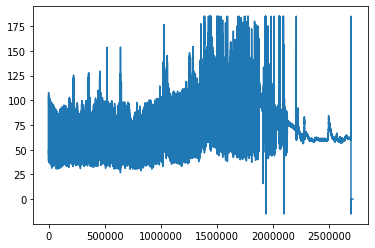

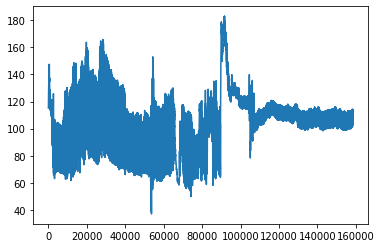

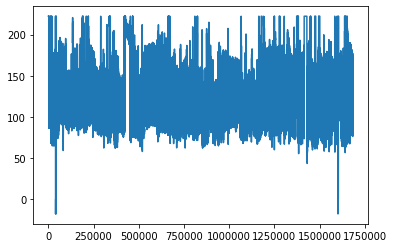

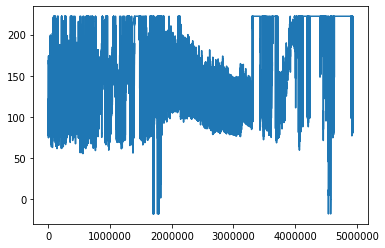

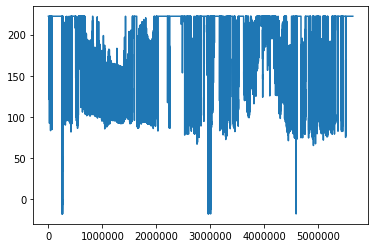

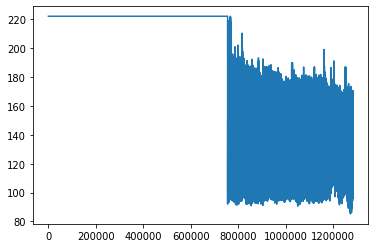

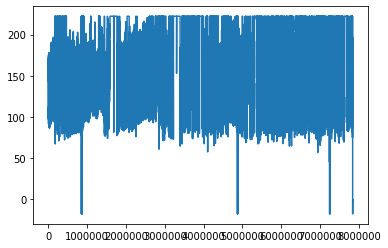

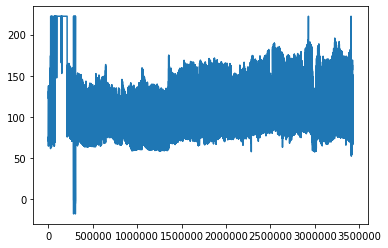

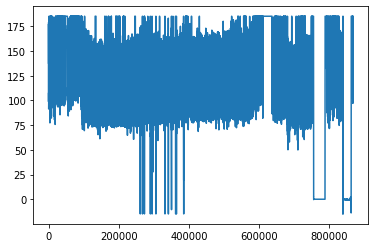

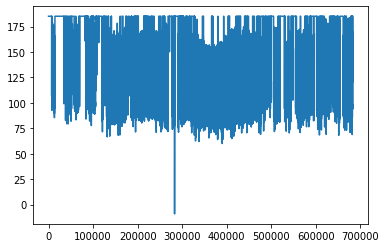

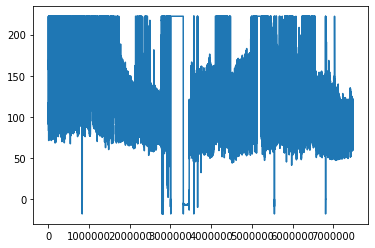

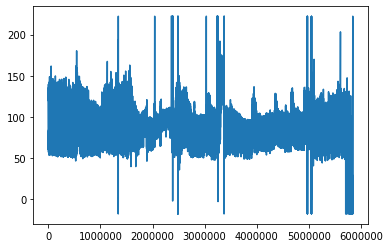

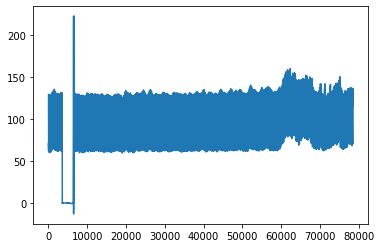

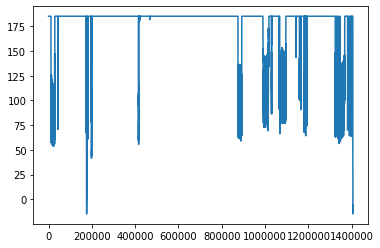

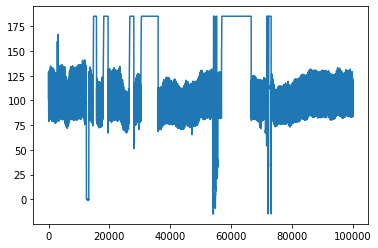

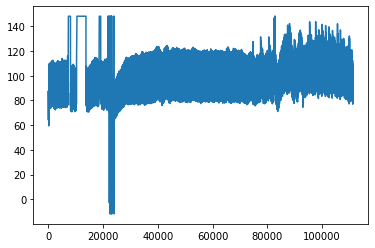

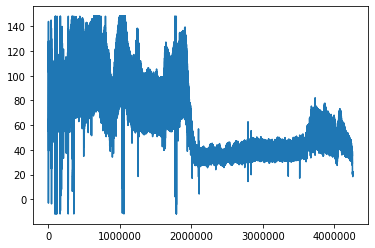

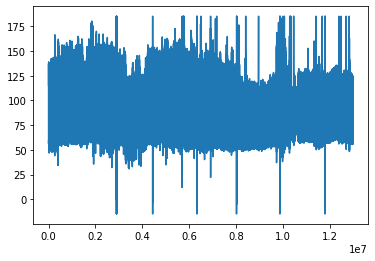

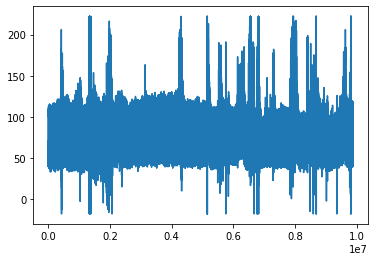

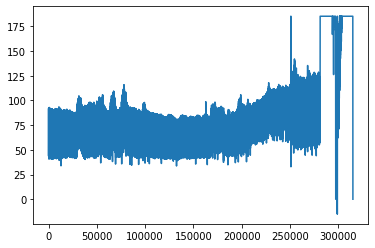

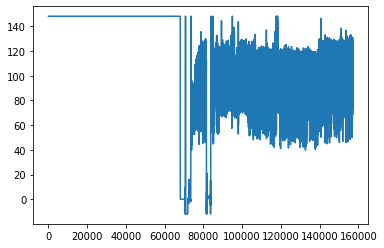

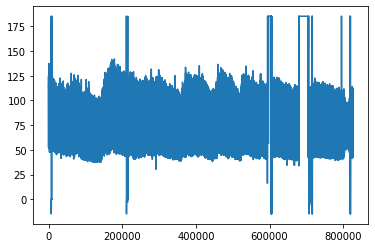

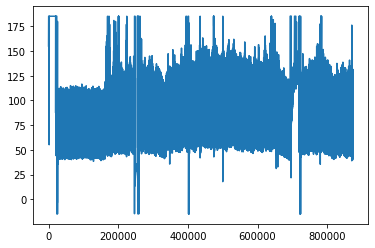

In [11]:
#take the fist 100 samples to see the rejected segements
for i in range(len(ABP_rm_list[:100])):
  x = ABP_rm_list[i]
  plt.figure()
  plt.plot(ABP_raw_signals[x])

###4.1.3 Remove flat ABP and PPG 


In [12]:
#join the two lists rm_list from ECG, and PPG_rm_list
ABP_list = pd.DataFrame(ABP_rm_list)
PPG_list = pd.DataFrame(PPG_rm_list)
total_list = ABP_list.merge(PPG_list,how="outer")
print('There are in total',len(total_list),"flat line segments in the joint list")

There are in total 65 flat line segments in the joint list


In [13]:
removal_list=total_list.values.tolist()
ABP_cl_signals = np.delete(ABP_raw_signals,total_list,0)
PPG_cl_signals = np.delete(PPG_raw_signals,total_list,0)
print('There are in total',len(ABP_cl_signals),"accepted ABP segments")
print('There are in total',len(PPG_cl_signals),"accepted PPG segments")

There are in total 35 accepted ABP segments
There are in total 35 accepted PPG segments


##4.2 Segmentation

In [0]:
def generate_segment_data(source,seg_len):
  signals =[]
  for signal in source:
    for i in range(int(len(signal)/seg_len)):
      seg = signal[seg_len*i:seg_len*(i+1)]
      signals.append(seg)
#convert list into a numpy array and change its dim from (num of records, seg_len, 1) to (num of records, seg_len)
  signals = np.asarray(list(map(lambda x: np.reshape(x,7500),signals)))

  return signals

In [15]:
ABP_seg_signals = generate_segment_data(ABP_cl_signals, 7500)
print('ABP segmented signals dim:', ABP_seg_signals.shape)

ABP segmented signals dim: (24524, 7500)


In [16]:
PPG_seg_signals = generate_segment_data(PPG_cl_signals, 7500)
print('PPG segmented signals dim:', PPG_seg_signals.shape)

PPG segmented signals dim: (24524, 7500)


##4.3 Process ABP data

###4.3.1 Peak Segmentation

Do another segementation based on each peak (i.e. segement 1min signals into each heart beat cycle)



In [0]:
def peak_segmentation(signal,distance = 40):
  valleys, _ = find_peaks(signal*-1, distance=distance)
  
  segments = []
  for i in range(len(valleys)-1):
    seg = signal[valleys[i]:valleys[i+1]]
    segments.append(seg)
  
  return segments

In [18]:
ABP_ps_signals = [peak_segmentation(i) for i in ABP_seg_signals]
print('ABP 1min segmented signals dim:', ABP_seg_signals.shape)
print('ABP cycle segmented signals no. of samples:', len(ABP_ps_signals))

ABP 1min segmented signals dim: (24524, 7500)
ABP cycle segmented signals no. of samples: 24524


###4.3.2 Flat peak removal

After 1min signal is segmented to each cycle, remove cycle that has more than 5% flat lines; during which, if more than 10% cycles contains 5% flatline, remove the entire 1min signal

In [0]:
#signals: A list of list (i.e. a list of 1 min signals that contains cyclic segments: ABP_ps_signals)
#cyc_ratio: threhold for flat line removal for a cycle
#seg_ratio: threhold to remove the whole 1min signal
def flat_peak_remove(signals,cyc_ratio = 0.05, seg_ratio = 0.1):

  clean_segments = []
  remove_index = [] 
  for i in range(len(signals)):
    #in case some lists are empty
    if signals[i] == []: 
      remove_index.append(i) 
      continue  
    
    #this returns a list of cleaned cycles (<5% flatline) and a list of cycles that has more than
    #5% flatline    
    clean_sig, rm_sig = flat_line(signals[i],0,cyc_ratio)
    
    if len(rm_sig)/(len(clean_sig) + len(rm_sig)) >= seg_ratio: 
      remove_index.append(i)
      continue
    
    clean_segments.append(clean_sig)

  return clean_segments, remove_index

In [0]:
ABP_fpr_signals, remove_index = flat_peak_remove(ABP_ps_signals,0.05,0.1)

In [22]:
print('ABP 1min segmented signals that has more than 10% cycles has flatline exceeding 5%:', len(remove_index))
print('Cleaned ABP 1min segmented signals:', len(ABP_fpr_signals))

ABP 1min segmented signals that has more than 10% cycles has flatline exceeding 5%: 15422
Cleaned ABP 1min segmented signals: 9102


###4.3.3 Remove PPG data

Remove PPG data that overlaps with ABP remove_index, since no ground truth BP value can be generated for those PPG data

In [23]:
PPG_fpr_signals = np.delete(PPG_seg_signals,remove_index,0)
print('There are in total',len(ABP_fpr_signals),"accepted ABP 1min segments")
print('There are in total',len(PPG_fpr_signals),"accepted PPG 1min segments")

There are in total 9102 accepted ABP 1min segments
There are in total 9102 accepted PPG 1min segments


###4.3.4 Generate ground truth

In [0]:
#A function that returns average systolic and diastolic value of a 1min data
#Input signals: ABP_fpr_signals
def bp_ground_truth(signals):
  gt_ls = []
  for i in range(len(signals)):
    cycles = signals[i]    #a list of cycles in 1min signal
    
    cyc_sys_list = []
    cyc_dia_list = []
    for j in range(len(cycles)):
      cyc_sys_list.append(max(cycles[j]))
      cyc_dia_list.append(cycles[j][0])

    gt_ls.append([np.average(np.asarray(cyc_sys_list)),
                  np.average(np.asarray(cyc_dia_list))])

  return gt_ls

In [25]:
gt_ls = bp_ground_truth(ABP_fpr_signals)
print("Ground truth list has", len(gt_ls), "samples")

Ground truth list has 9102 samples


##4.4 Process PPG raw data
Only do normalization, bandpass and hempal on PPG signals, not on ABP, since APB's waveform will be the groundtruth for blood pressure.

###4.4.1 Normalization

In [26]:
PPG_norm_signals = [sklearn.preprocessing.scale(i) for i in PPG_fpr_signals]

C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:1

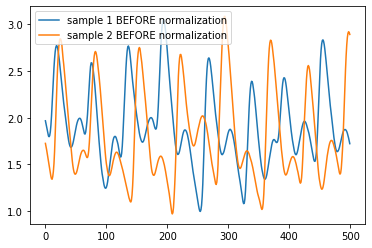

In [27]:
plt.plot(PPG_fpr_signals[0][0:500],label="sample 1 BEFORE normalization")
plt.plot(PPG_fpr_signals[2][0:500],label="sample 2 BEFORE normalization")
plt.legend()

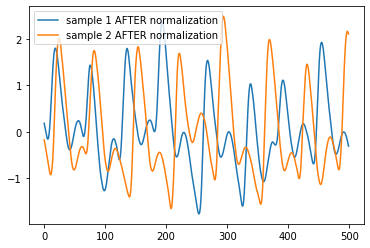

In [28]:
plt.plot(PPG_norm_signals[0][0:500],label="sample 1 AFTER normalization")
plt.plot(PPG_norm_signals[2][0:500],label="sample 2 AFTER normalization")
plt.legend()

###4.4.2 Band pass filter



In [0]:
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [33]:
PPG_bf_signals = []
for i in range(len(PPG_norm_signals)):
  PPG_bf_signal =butter_bandpass_filter(PPG_norm_signals[i],0.5,8,300,order=4)
  PPG_bf_signals.append(PPG_bf_signal)
  if i%10000 == 0:
      print("Processing on", i, "th sample")
print("After band pass filtering, there are:", len(PPG_bf_signals), "PPG records")

Processing on 0 th sample
After band pass filtering, there are: 9102 PPG records


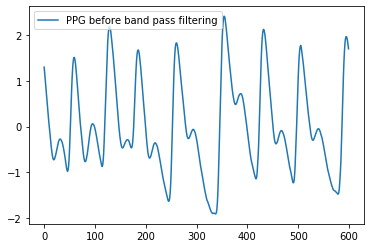

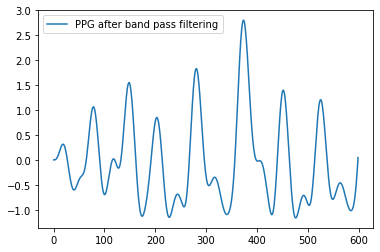

In [35]:
plt.plot(PPG_norm_signals[1][:600],label="PPG before band pass filtering")
plt.legend()
plt.figure()
plt.plot(PPG_bf_signals[1][:600], label="PPG after band pass filtering")
plt.legend()

###4.4.3 Hampel filter

The efffectiveness of hampel filter depends on how we play the two parameters: window_size and number of sigmas. 

In [0]:
#use numba to improve the speed of for loop
@jit(nopython=True)
def hampel_filter_forloop_numba(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    indices = []
    
    for i in range((window_size),(n - window_size)):
        x0 = np.nanmedian(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.nanmedian(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

In [37]:
PPG_hf_signals=[]
PPG_index=[]
for i in range(len(PPG_bf_signals)):
  if i%10000 == 0:
    print("hampel filering at", i+1, "th sample...")
  PPG_hf_signal, indices = hampel_filter_forloop_numba(PPG_bf_signals[i], 6)
  PPG_hf_signals.append(PPG_hf_signal)
  if indices != []:
    PPG_index.append([i,indices])
print("After Hample filtering, there are:", len(PPG_hf_signals), "PPG segments")
print("There are total", len(PPG_index),"PPG segements identified with outliers")

hampel filering at 1 th sample...
After Hample filtering, there are: 9102 PPG segments
There are total 0 PPG segements identified with outliers


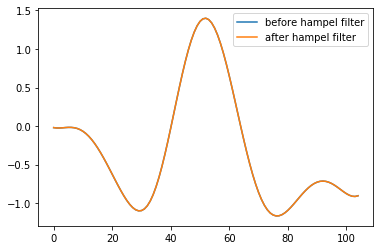

In [38]:
plt.plot(PPG_bf_signals[1][400:505], label = "before hampel filter")
plt.plot(PPG_hf_signals[1][400:505], label = "after hampel filter")
plt.legend()

# 5.Applied above steps to all data

In [0]:
#PPG 1min data
PPG_hf_signals
#label
gt_ls

In [0]:
def process_data(dir):
  


#6. Save all data

In [0]:
with open('D:/WFDB//matched/BP/BP_data.pkl', "wb") as fp:
  pickle.dump(PPG_hf_signals,fp)

with open('D:/WFDB//matched/BP/BP_label.pkl', "wb") as fp:
  pickle.dump(gt_ls,fp)